# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [3]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [4]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [5]:
import time
import gc

In [6]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
import os
import torch
import torchvision
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
from multiprocessing import Process
from torch.utils.data import TensorDataset, DataLoader
import math

In [8]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

# Specify parameters

In [9]:
file_name = "../OD_pair/GEANT-OD_pair.csv"  # the input filename
nodes = 23  # 23 nodes in the traffic matrix

history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'ConvLSTM'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
nodes * nodes

529

In [11]:
y_true_fn

'ConvLSTM_true_TM-minmax-10-1.pkl'

In [12]:
y_pred_fn

'ConvLSTM_pred_TM-minmax-10-1.pkl'

# Load data

In [13]:
df = pd.read_csv(file_name)

In [14]:
df.head()

,time,OD_1-1,OD_1-2,OD_1-3,OD_1-4,OD_1-5,OD_1-6,OD_1-7,OD_1-8,OD_1-9,...,OD_23-14,OD_23-15,OD_23-16,OD_23-17,OD_23-18,OD_23-19,OD_23-20,OD_23-21,OD_23-22,OD_23-23
0,2005-05-04-15-30,0.0,16760.79111,12407.777780,10453.848890,1468.631111,4768.444444,25290.37333,2468.515556,7984.213333,...,0.0,211.395556,1212.666667,1026.391111,51508.78222,1488.951111,175293.2444,3247.164444,14.106667,0.0
1,2005-05-04-15-45,0.0,16346.46222,9373.208889,8439.048889,1032.906667,1649.520000,14433.05778,3182.986667,7243.173333,...,0.0,190.142222,1079.751111,529.617778,44913.43111,1410.400000,148162.8711,3669.173333,6.880000,0.0
2,2005-05-04-16-00,0.0,16755.22667,10638.302220,12623.520000,721.226667,1693.057778,17066.67556,5304.195556,6696.844444,...,0.0,51.048889,1750.631111,81.760000,47603.85778,1016.977778,154312.8711,3452.320000,24.488889,0.0
3,2005-05-04-16-15,0.0,18488.00889,12263.697780,13389.128890,995.600000,2984.231111,13325.22667,6248.248889,5719.804444,...,0.0,217.911111,3313.120000,356.000000,47023.99111,1092.017778,148199.6622,3300.613333,36.951111,0.0
4,2005-05-04-16-30,0.0,13748.27556,11323.333330,14048.426670,804.044444,2698.124444,16651.25333,5761.528889,5088.204444,...,0.0,292.071111,4479.644444,541.288889,47737.10222,1139.217778,147601.5467,4073.137778,59.848889,0.0


Parse the time column:

In [15]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [16]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [17]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('15T') 

In [18]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [19]:
df_ts.index[train_length:][0]

Timestamp('2005-08-02 09:30:00', freq='15T')

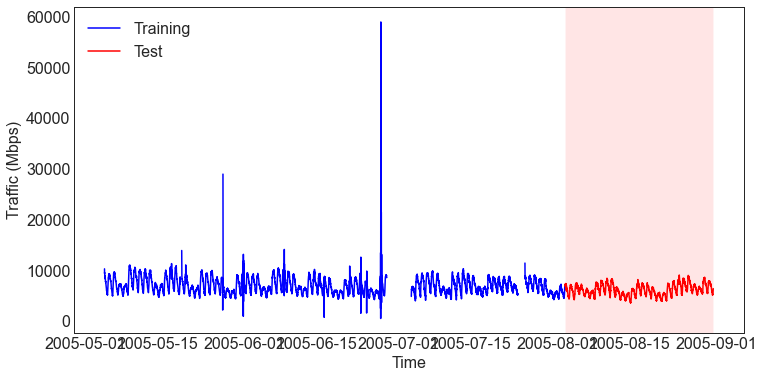

In [20]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [21]:
max_list = np.max(data[:train_length], axis=0)

In [22]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [23]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [24]:
print(np.max(data[:train_length].flatten()))

1.0


In [25]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [26]:
print(np.max(data.flatten()))

4.931113265982958


In [27]:
print(np.min(data.flatten()))

-0.003975552580138194


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [28]:
x_data = []
y_data = []

In [29]:
length = data.shape[0]
print(length)

10769


In [30]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [31]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [32]:
x_data.shape

(10759, 10, 529)

In [33]:
y_data.shape

(10759, 1, 529)

Reshape x_data as required by ConvLSTM models.

**This format is required by ConvLSTM: [data size, input historical steps, channel, nodes, nodes].**

In [34]:
# x_data = np.swapaxes(x_data, 1, 2)
x_data = x_data.reshape(x_data.shape[0], x_data.shape[1], 1, nodes, nodes)
x_data.shape

(10759, 10, 1, 23, 23)

Reshape y_data too:

In [35]:
y_data.shape

(10759, 1, 529)

In [36]:
y_data = y_data.reshape(y_data.shape[0], y_data.shape[1], 1, nodes, nodes)
y_data.shape

(10759, 1, 1, 23, 23)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [37]:
test_length = test_length - horizon + 1

In [38]:
train_valid_length = x_data.shape[0] - test_length

In [39]:
train_valid_length

8606

We further split a valid data set for hyper parameter tuning:

In [40]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [41]:
train_length

6884

In [42]:
valid_length

1722

In [43]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [44]:
X_train.shape

(6884, 10, 1, 23, 23)

In [45]:
y_train.shape

(6884, 1, 1, 23, 23)

In [46]:
X_valid.shape

(1722, 10, 1, 23, 23)

In [47]:
y_valid.shape

(1722, 1, 1, 23, 23)

In [48]:
X_test.shape

(2153, 10, 1, 23, 23)

In [49]:
y_test.shape

(2153, 1, 1, 23, 23)

# Build Model

We aim to build a Seq2Seq model with ConvLSTM:

In [50]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [51]:
class EncoderDecoderConvLSTM(nn.Module):
    def __init__(self, nf, in_chan):
        super(EncoderDecoderConvLSTM, self).__init__()

        """ ARCHITECTURE 

        # Encoder (ConvLSTM)
        # Encoder Vector (final hidden state of encoder)
        # Decoder (ConvLSTM) - takes Encoder Vector as input
        # Decoder (3D CNN) - produces regression predictions for our model

        """
        self.encoder_1_convlstm = ConvLSTMCell(input_dim=in_chan,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.encoder_2_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_1_convlstm = ConvLSTMCell(input_dim=nf,  # nf + 1
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_2_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_CNN = nn.Conv3d(in_channels=nf,
                                     out_channels=1,
                                     kernel_size=(1, 3, 3),
                                     padding=(0, 1, 1))


    def autoencoder(self, x, seq_len, future_step, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4):

        outputs = []

        # encoder
        for t in range(seq_len):
            h_t, c_t = self.encoder_1_convlstm(input_tensor=x[:, t, :, :],
                                               cur_state=[h_t, c_t])  # we could concat to provide skip conn here
            h_t2, c_t2 = self.encoder_2_convlstm(input_tensor=h_t,
                                                 cur_state=[h_t2, c_t2])  # we could concat to provide skip conn here

        # encoder_vector
        encoder_vector = h_t2

        # decoder
        for t in range(future_step):
            h_t3, c_t3 = self.decoder_1_convlstm(input_tensor=encoder_vector,
                                                 cur_state=[h_t3, c_t3])  # we could concat to provide skip conn here
            h_t4, c_t4 = self.decoder_2_convlstm(input_tensor=h_t3,
                                                 cur_state=[h_t4, c_t4])  # we could concat to provide skip conn here
            encoder_vector = h_t4
            outputs += [h_t4]  # predictions

        outputs = torch.stack(outputs, 1)
        outputs = outputs.permute(0, 2, 1, 3, 4)
        outputs = self.decoder_CNN(outputs)
        outputs = torch.nn.Sigmoid()(outputs)

        return outputs

    def forward(self, x, future_seq=0, hidden_state=None):

        """
        Parameters
        ----------
        input_tensor:
            5-D Tensor of shape (b, t, c, h, w)        #   batch, time, channel, height, width
        """

        # find size of different input dimensions
        b, seq_len, _, h, w = x.size()

        # initialize hidden states
        h_t, c_t = self.encoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t2, c_t2 = self.encoder_2_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t3, c_t3 = self.decoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t4, c_t4 = self.decoder_2_convlstm.init_hidden(batch_size=b, image_size=(h, w))

        # autoencoder forward
        outputs = self.autoencoder(x, seq_len, future_seq, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4)

        return outputs

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [52]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [1e-2, 1e-3, 1e-4]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # model parameters
    "n_hidden_dim": hp.choice('n_hidden_dim', [16, 32, 64])
}

In [53]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x20a526a08c8>,
 'lr': <hyperopt.pyll.base.Apply at 0x20a526b6a88>,
 'epochs': <hyperopt.pyll.base.Apply at 0x20a526af408>,
 'patience': <hyperopt.pyll.base.Apply at 0x20a526af3c8>,
 'n_hidden_dim': <hyperopt.pyll.base.Apply at 0x20a4fb90b08>}

In [54]:
# clear memory 
gc.collect()

3178

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        
        # Create model
        class TMLightning(pl.LightningModule):
        
            def __init__(self, hparams=None, model=None):
                super(TMLightning, self).__init__()
        
                # default config
                self.normalize = False
                self.model = model
        
                # Training config
                self.criterion = torch.nn.MSELoss()
                self.batch_size = params['batch_size']
                self.n_steps_past = history
                self.n_steps_ahead = horizon
        
            def forward(self, x):
                x = x.to(device)
        
                output = self.model(x, future_seq=self.n_steps_ahead)
        
                return output
        
            def training_step(self, batch, batch_idx):
                x, y = batch
                y_hat = self.forward(x)
        
                loss = self.criterion(y_hat, y)
        
                # save learning_rate
                lr_saved = self.trainer.optimizers[0].param_groups[-1]['lr']
                lr_saved = torch.scalar_tensor(lr_saved).cuda()
        
                tensorboard_logs = {'train_mse_loss': loss,
                                    'learning_rate': lr_saved}
        
                return {'loss': loss, 'log': tensorboard_logs}
            
            def validation_step(self, batch, batch_idx):
                x, y = batch
                y_hat = self.forward(x)
                loss = self.criterion(y_hat, y)
                self.log('val_loss', loss)
                return {'val_loss': loss, 'log': {'val_loss': loss}}
        
            def validation_epoch_end(self, outputs):
                val_loss_mean = sum([o['val_loss'] for o in outputs]) / len(outputs)
                # show val_acc in progress bar but only log val_loss
                results = {'progress_bar': {'val_loss': val_loss_mean.item()}, 'log': {'val_loss': val_loss_mean.item()},
                        'val_loss': val_loss_mean.item()}
                return results
        
            def test_step(self, batch, batch_idx):
                # OPTIONAL
                x, y = batch
                y_hat = self.forward(x)
                return {'test_loss': self.criterion(y_hat, y)}
        
            def test_end(self, outputs):
                # OPTIONAL
                avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
                tensorboard_logs = {'test_loss': avg_loss}
                return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
        
            def configure_optimizers(self):
                return torch.optim.Adam(self.parameters(), lr=params['lr'], betas=(0.9, 0.98))
        
            def train_dataloader(self):
                tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
                tensor_y_train = torch.Tensor(y_train)
        
                train_dataset = TensorDataset(tensor_x_train, tensor_y_train)  # create datset
                train_loader = DataLoader(train_dataset,
                    batch_size=self.batch_size,
                    shuffle=True)  # create dataloader
        
                return train_loader
            
            def val_dataloader(self):
                tensor_x_valid = torch.Tensor(X_valid) # transform to torch tensor
                tensor_y_valid = torch.Tensor(y_valid)
        
                valid_dataset = TensorDataset(tensor_x_valid, tensor_y_valid)  # create datset
                valid_loader = DataLoader(valid_dataset,
                    batch_size=self.batch_size,
                    shuffle=True)  # create dataloader
        
                return valid_loader
        
            def test_dataloader(self):
                tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
                tensor_y_test = torch.Tensor(y_test)
        
                test_dataset = TensorDataset(tensor_x_test, tensor_y_test)  # create datset
                test_loader = DataLoader(test_dataset,
                    batch_size=self.batch_size,
                    shuffle=False)  # create dataloader
        
                return test_loader
        
        conv_lstm_model = EncoderDecoderConvLSTM(nf=params['n_hidden_dim'], in_chan=1)
        model = TMLightning(model=conv_lstm_model)
        model.to(device)
        
        # Training the model
        early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=params['patience'], verbose=False, mode='min')
        trainer = Trainer(max_epochs=params['epochs'], gpus=1, callbacks=[early_stop_callback])
        trainer.fit(model)
        
        # get val_loss
        val_loss = float(trainer.logged_metrics['val_loss'].cpu().numpy())
        
        # clear memory
        del conv_lstm_model
        del model
        del trainer
        gc.collect()

        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except Exception as e:
        print(e.message)
        return {'loss': None, 'status': STATUS_FAIL}

In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.011


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'lr': 0.01, 'n_hidden_dim': 32, 'patience': 5}                                        
  1%|▍                                           | 1/100 [03:51<6:21:53, 231.45s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.007


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 5}                                      
  2%|▉                                           | 2/100 [07:00<5:57:25, 218.83s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.014


Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                        
  3%|█▎                                          | 3/100 [08:26<4:49:23, 179.00s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 10}                                     
  4%|█▊                                          | 4/100 [11:31<4:49:00, 180.63s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.014


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 32, 'patience': 10}                                      
  5%|██▏                                        | 5/100 [34:09<14:05:06, 533.75s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 10}                                    
  6%|██▌                                        | 6/100 [36:10<10:42:22, 410.02s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.234


Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 0.152


Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 0.042


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.029


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.025


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.024


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 10}                                     
  7%|███                                         | 7/100 [40:06<9:14:26, 357.70s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.007


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 10}                                      
  8%|███▌                                        | 8/100 [43:02<7:45:18, 303.46s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.009


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                     
  9%|███▊                                       | 9/100 [58:52<12:34:07, 497.23s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.026


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.014


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.011


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.008


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 10%|████                                    | 10/100 [1:16:00<16:24:48, 656.54s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
 11%|████▍                                   | 11/100 [1:25:04<15:23:35, 622.65s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.014


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                     
 12%|████▊                                   | 12/100 [1:28:38<12:13:34, 500.16s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 32, 'patience': 5}                                       
 13%|█████▏                                  | 13/100 [1:33:27<10:33:23, 436.83s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                       
 14%|█████▋                                   | 14/100 [1:35:20<8:06:43, 339.57s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 10}                                     
 15%|██████▏                                  | 15/100 [1:43:47<9:12:29, 390.00s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.011


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 5}                                     
 16%|██████▌                                  | 16/100 [1:47:42<8:00:43, 343.38s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.013


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.009


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 5}                                      
 17%|██████▊                                 | 17/100 [2:01:54<11:26:11, 496.05s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.015


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.013


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.009


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                      
 18%|███████▍                                 | 18/100 [2:05:32<9:23:53, 412.61s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.012


Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'n_hidden_dim': 16, 'patience': 5}                                        
 19%|███████▌                                | 19/100 [2:27:26<15:22:09, 683.09s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
 20%|████████                                | 20/100 [2:30:24<11:48:45, 531.57s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.012


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
 21%|████████▍                               | 21/100 [2:35:33<10:11:41, 464.58s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 22%|█████████                                | 22/100 [2:39:02<8:24:15, 387.90s/trial, best loss: 0.00089226447744295]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
 23%|████████▉                              | 23/100 [2:49:06<9:41:06, 452.81s/trial, best loss: 0.0008918062085285783]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
 24%|█████████▎                             | 24/100 [2:53:50<8:29:18, 402.08s/trial, best loss: 0.0008918062085285783]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 25%|█████████▊                             | 25/100 [3:00:56<8:31:50, 409.48s/trial, best loss: 0.0008918062085285783]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.009


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 32, 'patience': 5}                                      
 26%|█████████▉                            | 26/100 [3:13:18<10:28:06, 509.27s/trial, best loss: 0.0008918062085285783]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.017


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.013


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.008


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 27%|██████████▎                           | 27/100 [3:22:10<10:27:52, 516.07s/trial, best loss: 0.0008918062085285783]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 28%|██████████▉                            | 28/100 [3:39:22<13:24:49, 670.68s/trial, best loss: 0.000888058275450021]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.017


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.008


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 10}                                      
 29%|███████████▎                           | 29/100 [3:53:09<14:09:16, 717.70s/trial, best loss: 0.000888058275450021]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.017


Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 30%|███████████▋                           | 30/100 [4:13:26<16:52:08, 867.55s/trial, best loss: 0.000888058275450021]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 31%|████████████                           | 31/100 [4:29:49<17:17:24, 902.09s/trial, best loss: 0.000888058275450021]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                      
 32%|████████████▍                          | 32/100 [4:43:24<16:32:48, 876.01s/trial, best loss: 0.000888058275450021]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.013


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.007


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                        
 33%|████████████▊                          | 33/100 [5:03:48<18:14:32, 980.18s/trial, best loss: 0.000888058275450021]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.010


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 10}                                      
 34%|█████████████▎                         | 34/100 [5:15:43<16:30:56, 900.86s/trial, best loss: 0.000888058275450021]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.010


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 35%|█████████████▎                        | 35/100 [5:36:21<18:05:28, 1001.97s/trial, best loss: 0.000888058275450021]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 10}                                      
 36%|█████████████▋                        | 36/100 [5:49:19<16:36:56, 934.64s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.020


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 37%|██████████████                        | 37/100 [6:00:25<14:56:47, 854.09s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 10}                                     
 38%|██████████████▍                       | 38/100 [6:10:42<13:29:09, 783.06s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.015


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.010


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.007


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 39%|██████████████▊                       | 39/100 [6:18:32<11:40:35, 689.10s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                       
 40%|███████████████▌                       | 40/100 [6:23:04<9:23:51, 563.86s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 10}                                      
 41%|███████████████▉                       | 41/100 [6:28:28<8:03:52, 492.07s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.017


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 5}                                       
 42%|████████████████▍                      | 42/100 [6:36:36<7:54:23, 490.75s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                      
 43%|████████████████▊                      | 43/100 [6:39:19<6:12:41, 392.30s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.011


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 10}                                     
 44%|█████████████████▏                     | 44/100 [6:59:09<9:49:35, 631.70s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                       
 45%|█████████████████                     | 45/100 [7:16:34<11:32:37, 755.60s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.024


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 5}                                       
 46%|█████████████████▉                     | 46/100 [7:22:56<9:39:13, 643.58s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.014


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 47%|██████████████████▎                    | 47/100 [7:26:38<7:36:55, 517.27s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 10}                                    
 48%|██████████████████▋                    | 48/100 [7:39:12<8:29:48, 588.23s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.025


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.013


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.009


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.007


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.01, 'n_hidden_dim': 16, 'patience': 5}                                        
 49%|██████████████████▌                   | 49/100 [7:56:44<10:18:07, 727.20s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.010


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
 50%|███████████████████▌                   | 50/100 [7:59:21<7:43:31, 556.24s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.008


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                     
 51%|███████████████████▉                   | 51/100 [8:05:57<6:55:00, 508.18s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.011


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                      
 52%|████████████████████▎                  | 52/100 [8:19:59<8:06:44, 608.43s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.014


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 10}                                      
 53%|████████████████████▋                  | 53/100 [8:35:05<9:06:20, 697.46s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.010


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 32, 'patience': 5}                                        
 54%|█████████████████████                  | 54/100 [8:36:33<6:34:34, 514.66s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 55%|█████████████████████▍                 | 55/100 [8:37:35<4:44:20, 379.12s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.010


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                      
 56%|█████████████████████▊                 | 56/100 [8:53:45<6:47:59, 556.36s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.012


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 57%|██████████████████████▏                | 57/100 [8:59:24<5:51:48, 490.89s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 10}                                     
 58%|██████████████████████▌                | 58/100 [9:09:13<6:04:24, 520.58s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.100


Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 0.028


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.024


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 59%|███████████████████████                | 59/100 [9:10:39<4:26:34, 390.12s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.017


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.011


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 32, 'patience': 5}                                        
 60%|███████████████████████▍               | 60/100 [9:26:45<6:15:14, 562.87s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 61%|███████████████████████▊               | 61/100 [9:28:16<4:33:50, 421.29s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 62%|████████████████████████▏              | 62/100 [9:42:29<5:48:45, 550.67s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 16, 'patience': 10}                                     
 63%|████████████████████████▌              | 63/100 [9:45:58<4:36:26, 448.30s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.140


Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 0.030


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.024


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.015


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.014


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.013


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.012


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.011


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.010


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.009


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.008


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 64%|████████████████████████▉              | 64/100 [9:49:32<3:46:46, 377.95s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.014


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 65%|█████████████████████████▎             | 65/100 [9:59:51<4:22:38, 450.25s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.009


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 66%|█████████████████████████             | 66/100 [10:10:06<4:43:13, 499.81s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.008


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 67%|█████████████████████████▍            | 67/100 [10:19:53<4:49:11, 525.80s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 68%|█████████████████████████▊            | 68/100 [10:26:58<4:24:19, 495.62s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.008


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 69%|██████████████████████████▏           | 69/100 [10:35:29<4:18:26, 500.20s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.009


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 70%|██████████████████████████▌           | 70/100 [10:49:44<5:03:24, 606.83s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 71%|██████████████████████████▉           | 71/100 [10:57:19<4:31:10, 561.06s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 72%|███████████████████████████▎          | 72/100 [11:00:51<3:33:04, 456.57s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 73%|███████████████████████████▋          | 73/100 [11:13:18<4:04:38, 543.65s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 5}                                       
 74%|████████████████████████████          | 74/100 [11:24:52<4:15:09, 588.82s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                        
 75%|████████████████████████████▌         | 75/100 [11:31:10<3:38:55, 525.43s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.008


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 76%|████████████████████████████▉         | 76/100 [11:40:41<3:35:36, 539.02s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 10}                                    
 77%|█████████████████████████████▎        | 77/100 [11:44:46<2:52:50, 450.90s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.013


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.007


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 78%|█████████████████████████████▋        | 78/100 [12:18:40<5:39:30, 925.91s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 5}                                       
 79%|██████████████████████████████        | 79/100 [12:37:30<5:45:25, 986.95s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                        
 80%|██████████████████████████████▍       | 80/100 [12:40:38<4:09:10, 747.51s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.024


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.024


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 10}                                      
 81%|██████████████████████████████▊       | 81/100 [12:45:37<3:14:04, 612.85s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 82%|███████████████████████████████▏      | 82/100 [12:50:39<2:35:52, 519.57s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.009


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                     
 83%|███████████████████████████████▌      | 83/100 [13:02:40<2:44:17, 579.86s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.025


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.013


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.011


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.009


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 5}                                       
 84%|███████████████████████████████▉      | 84/100 [13:19:42<3:10:01, 712.60s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.013


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 64, 'patience': 5}                                        
 85%|████████████████████████████████▎     | 85/100 [13:21:08<2:11:07, 524.51s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.024


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 32, 'patience': 10}                                      
 86%|████████████████████████████████▋     | 86/100 [13:25:53<1:45:38, 452.72s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 87%|█████████████████████████████████     | 87/100 [13:33:09<1:37:00, 447.73s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                     
 88%|█████████████████████████████████▍    | 88/100 [13:45:01<1:45:23, 526.93s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.012


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 89%|█████████████████████████████████▊    | 89/100 [14:04:58<2:13:29, 728.12s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.015


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.010


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 10}                                      
 90%|██████████████████████████████████▏   | 90/100 [14:21:17<2:13:53, 803.30s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.015


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 32, 'patience': 5}                                        
 91%|██████████████████████████████████▌   | 91/100 [14:22:42<1:28:10, 587.83s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.021. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 92%|████████████████████████████████████▊   | 92/100 [14:24:43<59:42, 447.87s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.007


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 93%|███████████████████████████████████▎  | 93/100 [14:38:33<1:05:38, 562.59s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.0001, 'n_hidden_dim': 64, 'patience': 5}                                      
 94%|███████████████████████████████████▋  | 94/100 [14:56:10<1:11:05, 710.85s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.005


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'lr': 0.001, 'n_hidden_dim': 16, 'patience': 10}                                     
 95%|████████████████████████████████████  | 95/100 [15:14:27<1:08:53, 826.73s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 65.5 K
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.012


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.006


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 96%|██████████████████████████████████████▍ | 96/100 [15:15:55<40:19, 605.00s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.019


Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'lr': 0.01, 'n_hidden_dim': 32, 'patience': 5}                                        
 97%|██████████████████████████████████████▊ | 97/100 [15:25:50<30:06, 602.04s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 260 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.040     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.016


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.004


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                       
 98%|███████████████████████████████████████▏| 98/100 [15:29:33<16:16, 488.35s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.007


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}                                      
 99%|███████████████████████████████████████▌| 99/100 [15:38:28<08:22, 502.33s/trial, best loss: 0.0008823273237794638]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.018


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.017


Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.003


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


100%|███████████████████████████████████████| 100/100 [15:51:55<00:00, 571.16s/trial, best loss: 0.0008823273237794638]


In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 16, 'epochs': 50, 'lr': 0.001, 'n_hidden_dim': 64, 'patience': 5}


In [59]:
# only for debug
'''
params = {'lr': 1e-4,
          'epochs': 10,
          'batch_size': 16,
          'patience': 5,
          'n_hidden_dim': 64}
'''

"\nparams = {'lr': 1e-4,\n          'epochs': 10,\n          'batch_size': 16,\n          'patience': 5,\n          'n_hidden_dim': 64}\n"

# Retrain the model with best hyperparameter

In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [61]:
class TMLightning(pl.LightningModule):

    def __init__(self, hparams=None, model=None):
        super(TMLightning, self).__init__()

        # default config
        self.normalize = False
        self.model = model

        # Training config
        self.criterion = torch.nn.MSELoss()
        self.batch_size = params['batch_size']
        self.n_steps_past = history
        self.n_steps_ahead = horizon

    def forward(self, x):
        x = x.to(device)

        output = self.model(x, future_seq=self.n_steps_ahead)

        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.criterion(y_hat, y)

        # save learning_rate
        lr_saved = self.trainer.optimizers[0].param_groups[-1]['lr']
        lr_saved = torch.scalar_tensor(lr_saved).cuda()

        tensorboard_logs = {'train_mse_loss': loss,
                            'learning_rate': lr_saved}

        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return {'val_loss': loss, 'log': {'val_loss': loss}}

    def validation_epoch_end(self, outputs):
        val_loss_mean = sum([o['val_loss'] for o in outputs]) / len(outputs)
        # show val_acc in progress bar but only log val_loss
        results = {'progress_bar': {'val_loss': val_loss_mean.item()}, 'log': {'val_loss': val_loss_mean.item()},
                   'val_loss': val_loss_mean.item()}
        return results

    def test_step(self, batch, batch_idx):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'test_loss': self.criterion(y_hat, y)}

    def test_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=params['lr'], betas=(0.9, 0.98))

    def train_dataloader(self):
        tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
        tensor_y_train = torch.Tensor(y_train)

        train_dataset = TensorDataset(tensor_x_train, tensor_y_train)  # create datset
        train_loader = DataLoader(train_dataset,
            batch_size=self.batch_size,
            shuffle=True)  # create dataloader

        return train_loader
    
    def val_dataloader(self):
        tensor_x_valid = torch.Tensor(X_valid) # transform to torch tensor
        tensor_y_valid = torch.Tensor(y_valid)

        valid_dataset = TensorDataset(tensor_x_valid, tensor_y_valid)  # create datset
        valid_loader = DataLoader(valid_dataset,
            batch_size=self.batch_size,
            shuffle=True)  # create dataloader

        return valid_loader

    def test_dataloader(self):
        tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
        tensor_y_test = torch.Tensor(y_test)

        test_dataset = TensorDataset(tensor_x_test, tensor_y_test)  # create datset
        test_loader = DataLoader(test_dataset,
            batch_size=self.batch_size,
            shuffle=False)  # create dataloader

        return test_loader

Create the model

In [62]:
conv_lstm_model = EncoderDecoderConvLSTM(nf=params['n_hidden_dim'], in_chan=1)
model = TMLightning(model=conv_lstm_model)
model.to(device)

TMLightning(
  (model): EncoderDecoderConvLSTM(
    (encoder_1_convlstm): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoder_2_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_1_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_2_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_CNN): Conv3d(64, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  )
  (criterion): MSELoss()
)

In [63]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,036,097 total parameters.
1,036,097 training parameters.


Training the model:

In [64]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=params['patience'], verbose=True, mode='min')
trainer = Trainer(max_epochs=params['epochs'], gpus=1, callbacks=[early_stop_callback])
start = time.time()
trainer.fit(model)
training_time = time.time() - start

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | EncoderDecoderConvLSTM | 1.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.144     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.021


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.011


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.002


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.001. Signaling Trainer to stop.


In [65]:
val_loss = float(trainer.logged_metrics['val_loss'].cpu().numpy())
val_loss

0.001000899588689208

# Evaluate the model on the test set

In [66]:
device

device(type='cuda', index=0)

In [67]:
tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test)

test_dataset = TensorDataset(tensor_x_test, tensor_y_test)  # create datset
test_loader = DataLoader(test_dataset,
                         batch_size=params['batch_size'],
                         shuffle=True)  # create dataloader

In [68]:
model.to(device)

TMLightning(
  (model): EncoderDecoderConvLSTM(
    (encoder_1_convlstm): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoder_2_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_1_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_2_convlstm): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_CNN): Conv3d(64, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  )
  (criterion): MSELoss()
)

In [69]:
prediction_list = []
true_value_list = []
start = time.time()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(inputs)
        prediction_list.append(outputs.cpu().numpy())
        true_value_list.append(labels.cpu().numpy())
prediction_time = time.time() - start

Reshape the data into multiple steps

In [70]:
y_true = np.concatenate(true_value_list)
y_pred = np.concatenate(prediction_list)
y_true = y_true.reshape(y_true.shape[0], y_true.shape[1], -1)
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)

In [71]:
y_true.shape

(2153, 1, 529)

In [72]:
y_pred.shape

(2153, 1, 529)

In [73]:
np.max(y_true.flatten())

4.9311132

In [74]:
np.min(y_true.flatten())

-0.0039755525

In [75]:
np.max(y_pred.flatten())

0.9904805

In [76]:
np.min(y_pred.flatten())

1.4975039e-05

Transform the data in the normal range:

In [77]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [78]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [79]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [80]:
y_true.shape

(2153, 1, 529)

In [81]:
y_pred.shape

(2153, 1, 529)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [82]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [83]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [84]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  565.5962986946106
Test time (in seconds):  2.016322612762451


In [90]:
print('Training time (in seconds) per epoch: ', 565.5962986946106 / 19)

Training time (in seconds) per epoch:  29.76822624708477


Calculate the RMSE and MAE for differnt time steps:

In [86]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  6.086485197270864
MAE:  1.9082302507119322


Plot the RMSE and MAE distributions for each time step:

In [87]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [88]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

ConvLSTM_TM-minmax_RMSE-10-1-step-1.pdf
ConvLSTM_TM-minmax_MAE-10-1-step-1.pdf


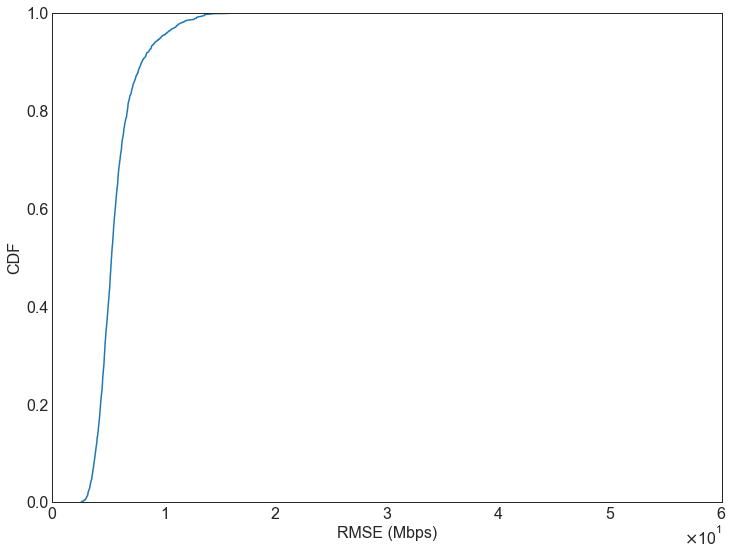

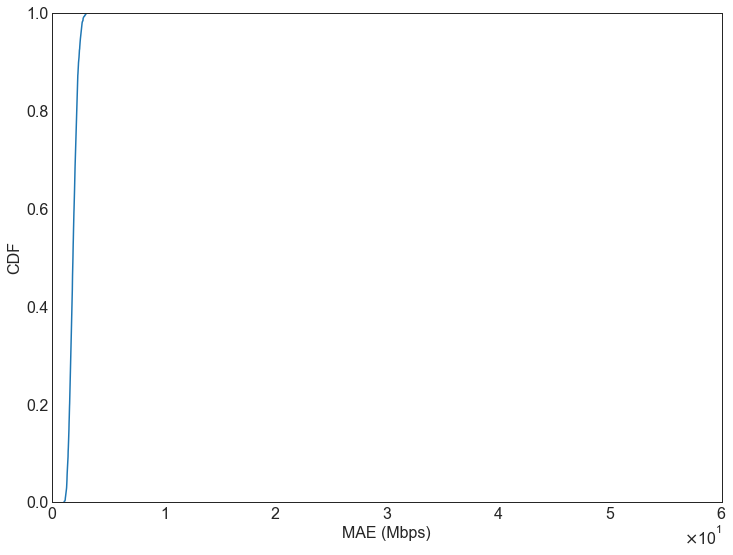

In [89]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)